In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2,
    'lines.markersize': 8
}

plt.rcParams.update(myparams)

from utils import Dataset, Estimator, Forecaster, Visualizer
from utils import D, M, get_norms_and_eigvals, get_means_and_variances, get_divergences_and_scores
from models import RegressionModel, LogisticModel

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
#figures_path = "figures/color/"
figures_path = "figures/gray/"

#format = "pdf"
format = "eps"

if figures_path == "figures/gray/":
    from cycler import cycler
    monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.']) *
                  cycler('linestyle', ['-', '--', ':', '-.']))
    plt.rc('axes', prop_cycle=monochrome)
    
figures_path += f"{format}/"

# Линейная регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  \sigma^2) $$

Сгенерируем синтетическую выборку

In [3]:
m = 1000 # n_samples
n = 20 # n_features

mu = np.zeros(n) # expectation of x
Sigma = np.identity(n) # covariance matrix of x

alpha = 1
sigma2 = 1

X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [17]:
norms, eigvals = get_norms_and_eigvals(X, B=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


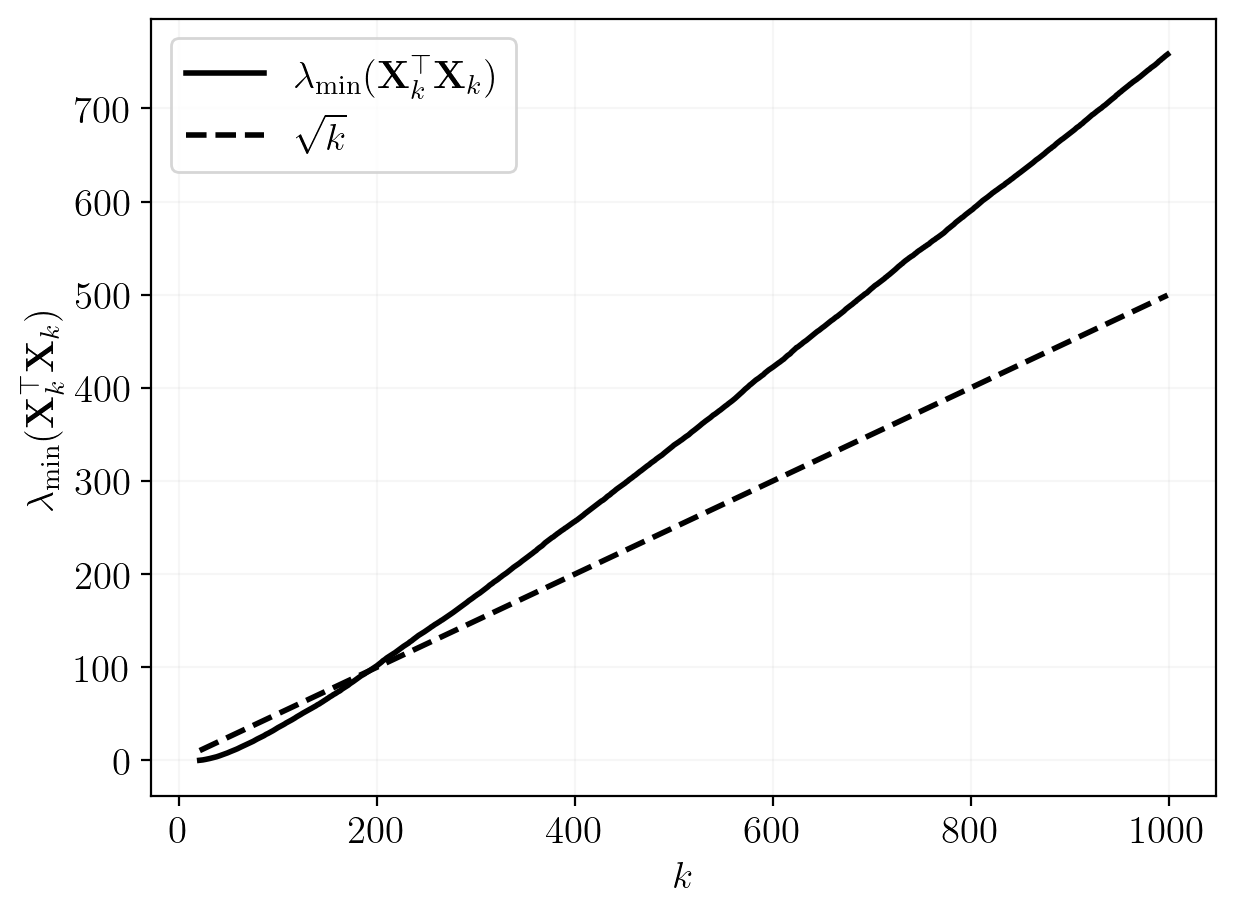

In [18]:
sample_sizes = np.arange(n+1, m)
plt.plot(sample_sizes, eigvals, label=r"$\lambda_{\min}(\mathbf{X}_k^\top \mathbf{X}_k)$")
plt.plot(sample_sizes, sample_sizes ** 1/2, label=r"$\sqrt{k}$")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\lambda_{\min}(\mathbf{X}_k^\top \mathbf{X}_k)$")

plt.tight_layout()
plt.savefig(figures_path+"lambda"+f".{format}", bbox_inches="tight")
plt.show()

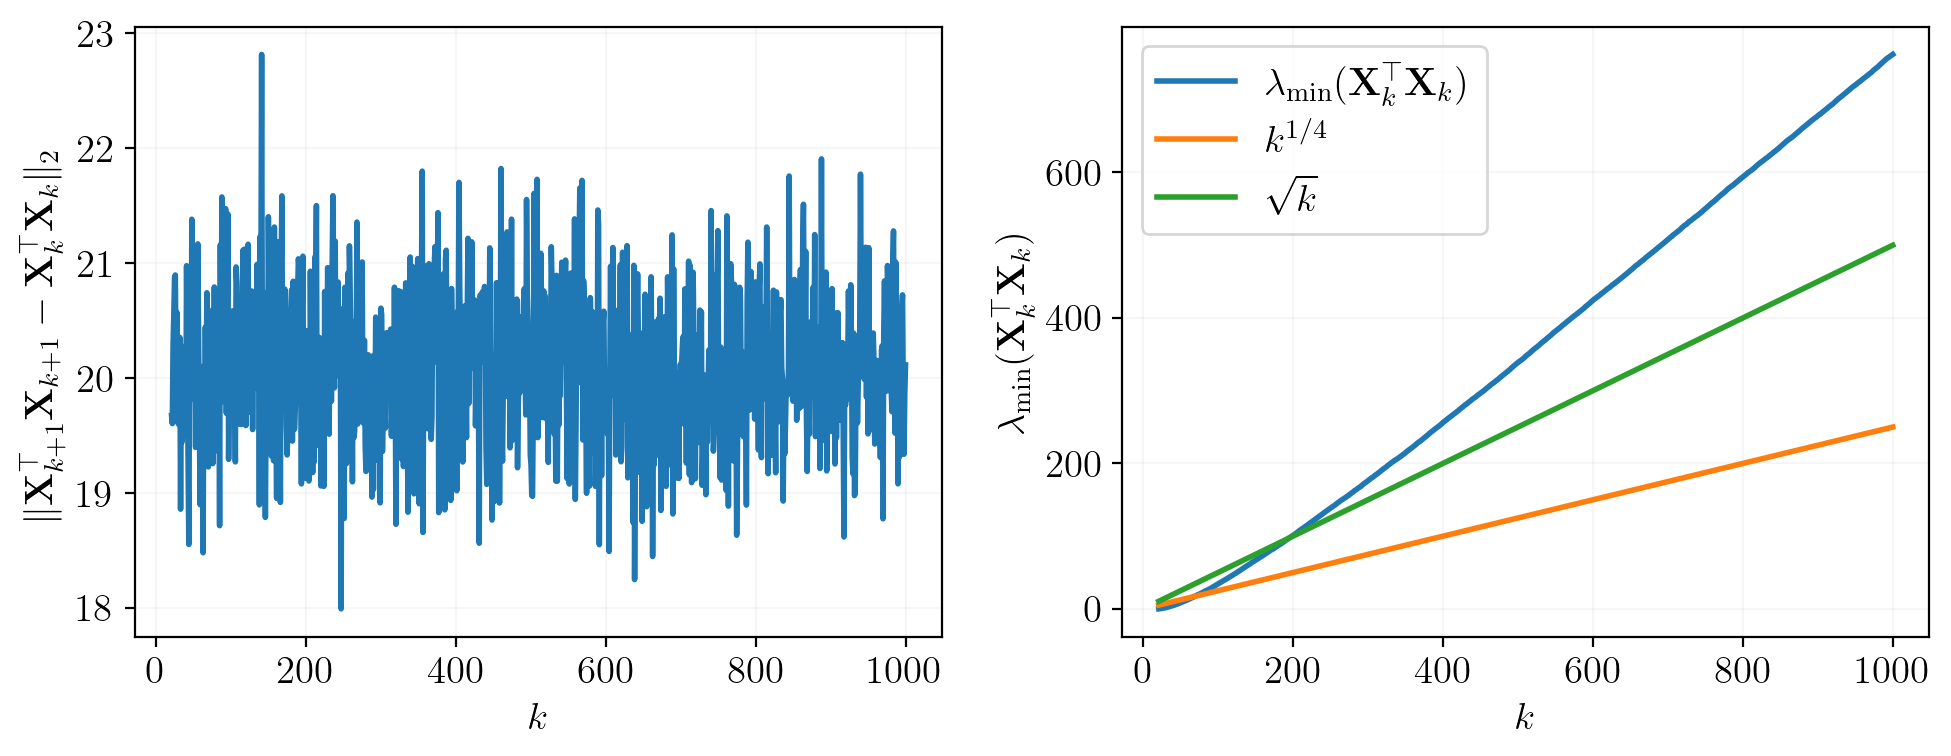

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sample_sizes = np.arange(n+1, m)

ax1.plot(sample_sizes, norms)
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\| \mathbf{X}_{k+1}^\top \mathbf{X}_{k+1} - \mathbf{X}_k^\top \mathbf{X}_k \|_2$")

ax2.plot(sample_sizes, eigvals, label=r"$\lambda_{\min}(\mathbf{X}_k^\top \mathbf{X}_k)$")
ax2.plot(sample_sizes, sample_sizes ** 1/4, label=r"$k^{1/4}$")
ax2.plot(sample_sizes, sample_sizes ** 1/2, label=r"$\sqrt{k}$")
ax2.legend()
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\lambda_{\min}(\mathbf{X}_k^\top \mathbf{X}_k)$")\

plt.tight_layout()
plt.show()

#### Сходимость предложенных функций 

In [4]:
sample_sizes = np.arange(n+1, m)
means, variances = get_means_and_variances(X, y, sample_sizes, "regression", sigma2, B=100)

# parameters for prior distribution of w
m0, Sigma0 = np.zeros(n), alpha**(-1)*np.identity(n)
divergences, scores = get_divergences_and_scores(X, y, m0, Sigma0, B=100)

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


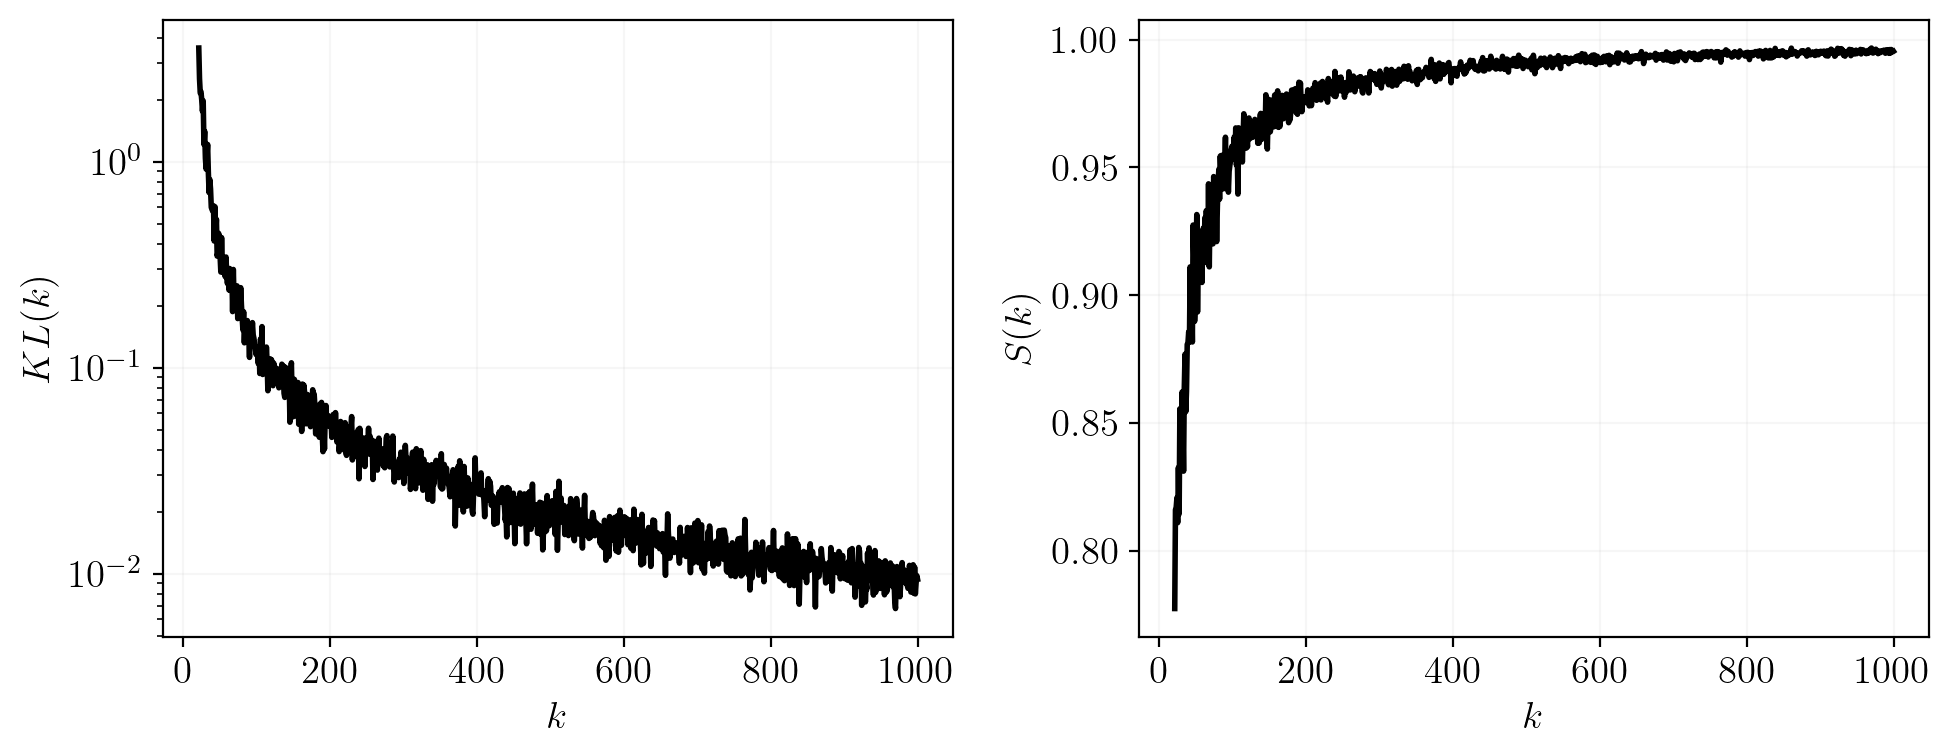

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(sample_sizes, divergences)
ax[0].set_yscale("log")
ax[0].set_ylabel(r"$KL(k)$")
ax[0].set_xlabel(r"$k$")

ax[1].plot(sample_sizes, scores)
#ax[1][1].set_yscale('log')
ax[1].set_ylabel(r"$S(k)$")
ax[1].set_xlabel(r"$k$")

plt.tight_layout()
plt.savefig(figures_path+"synthetic-regression-functions-KL-S"+f".{format}", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


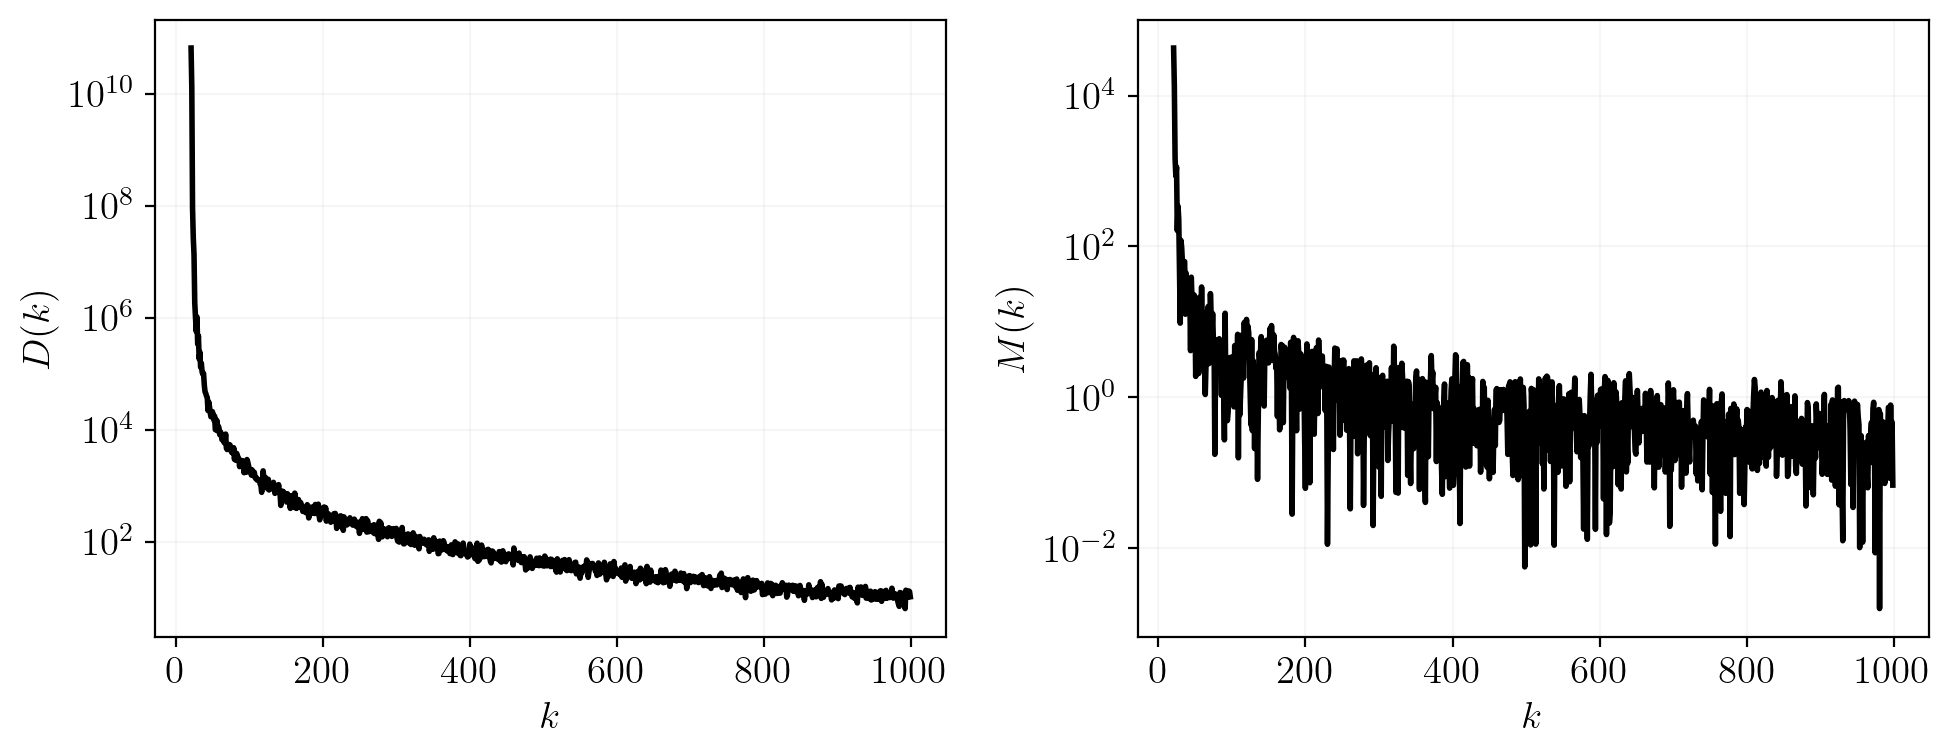

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(sample_sizes, D(means, variances))
ax[0].set_yscale("log")
ax[0].set_ylabel(r"$D(k)$")
ax[0].set_xlabel(r"$k$")

ax[1].plot(sample_sizes[:-1], M(means, variances))
ax[1].set_yscale('log')
ax[1].set_ylabel(r"$M(k)$")
ax[1].set_xlabel(r"$k$")

plt.tight_layout()
plt.savefig(figures_path+"synthetic-regression-functions-D-M"+f".{format}", bbox_inches="tight")
plt.show()

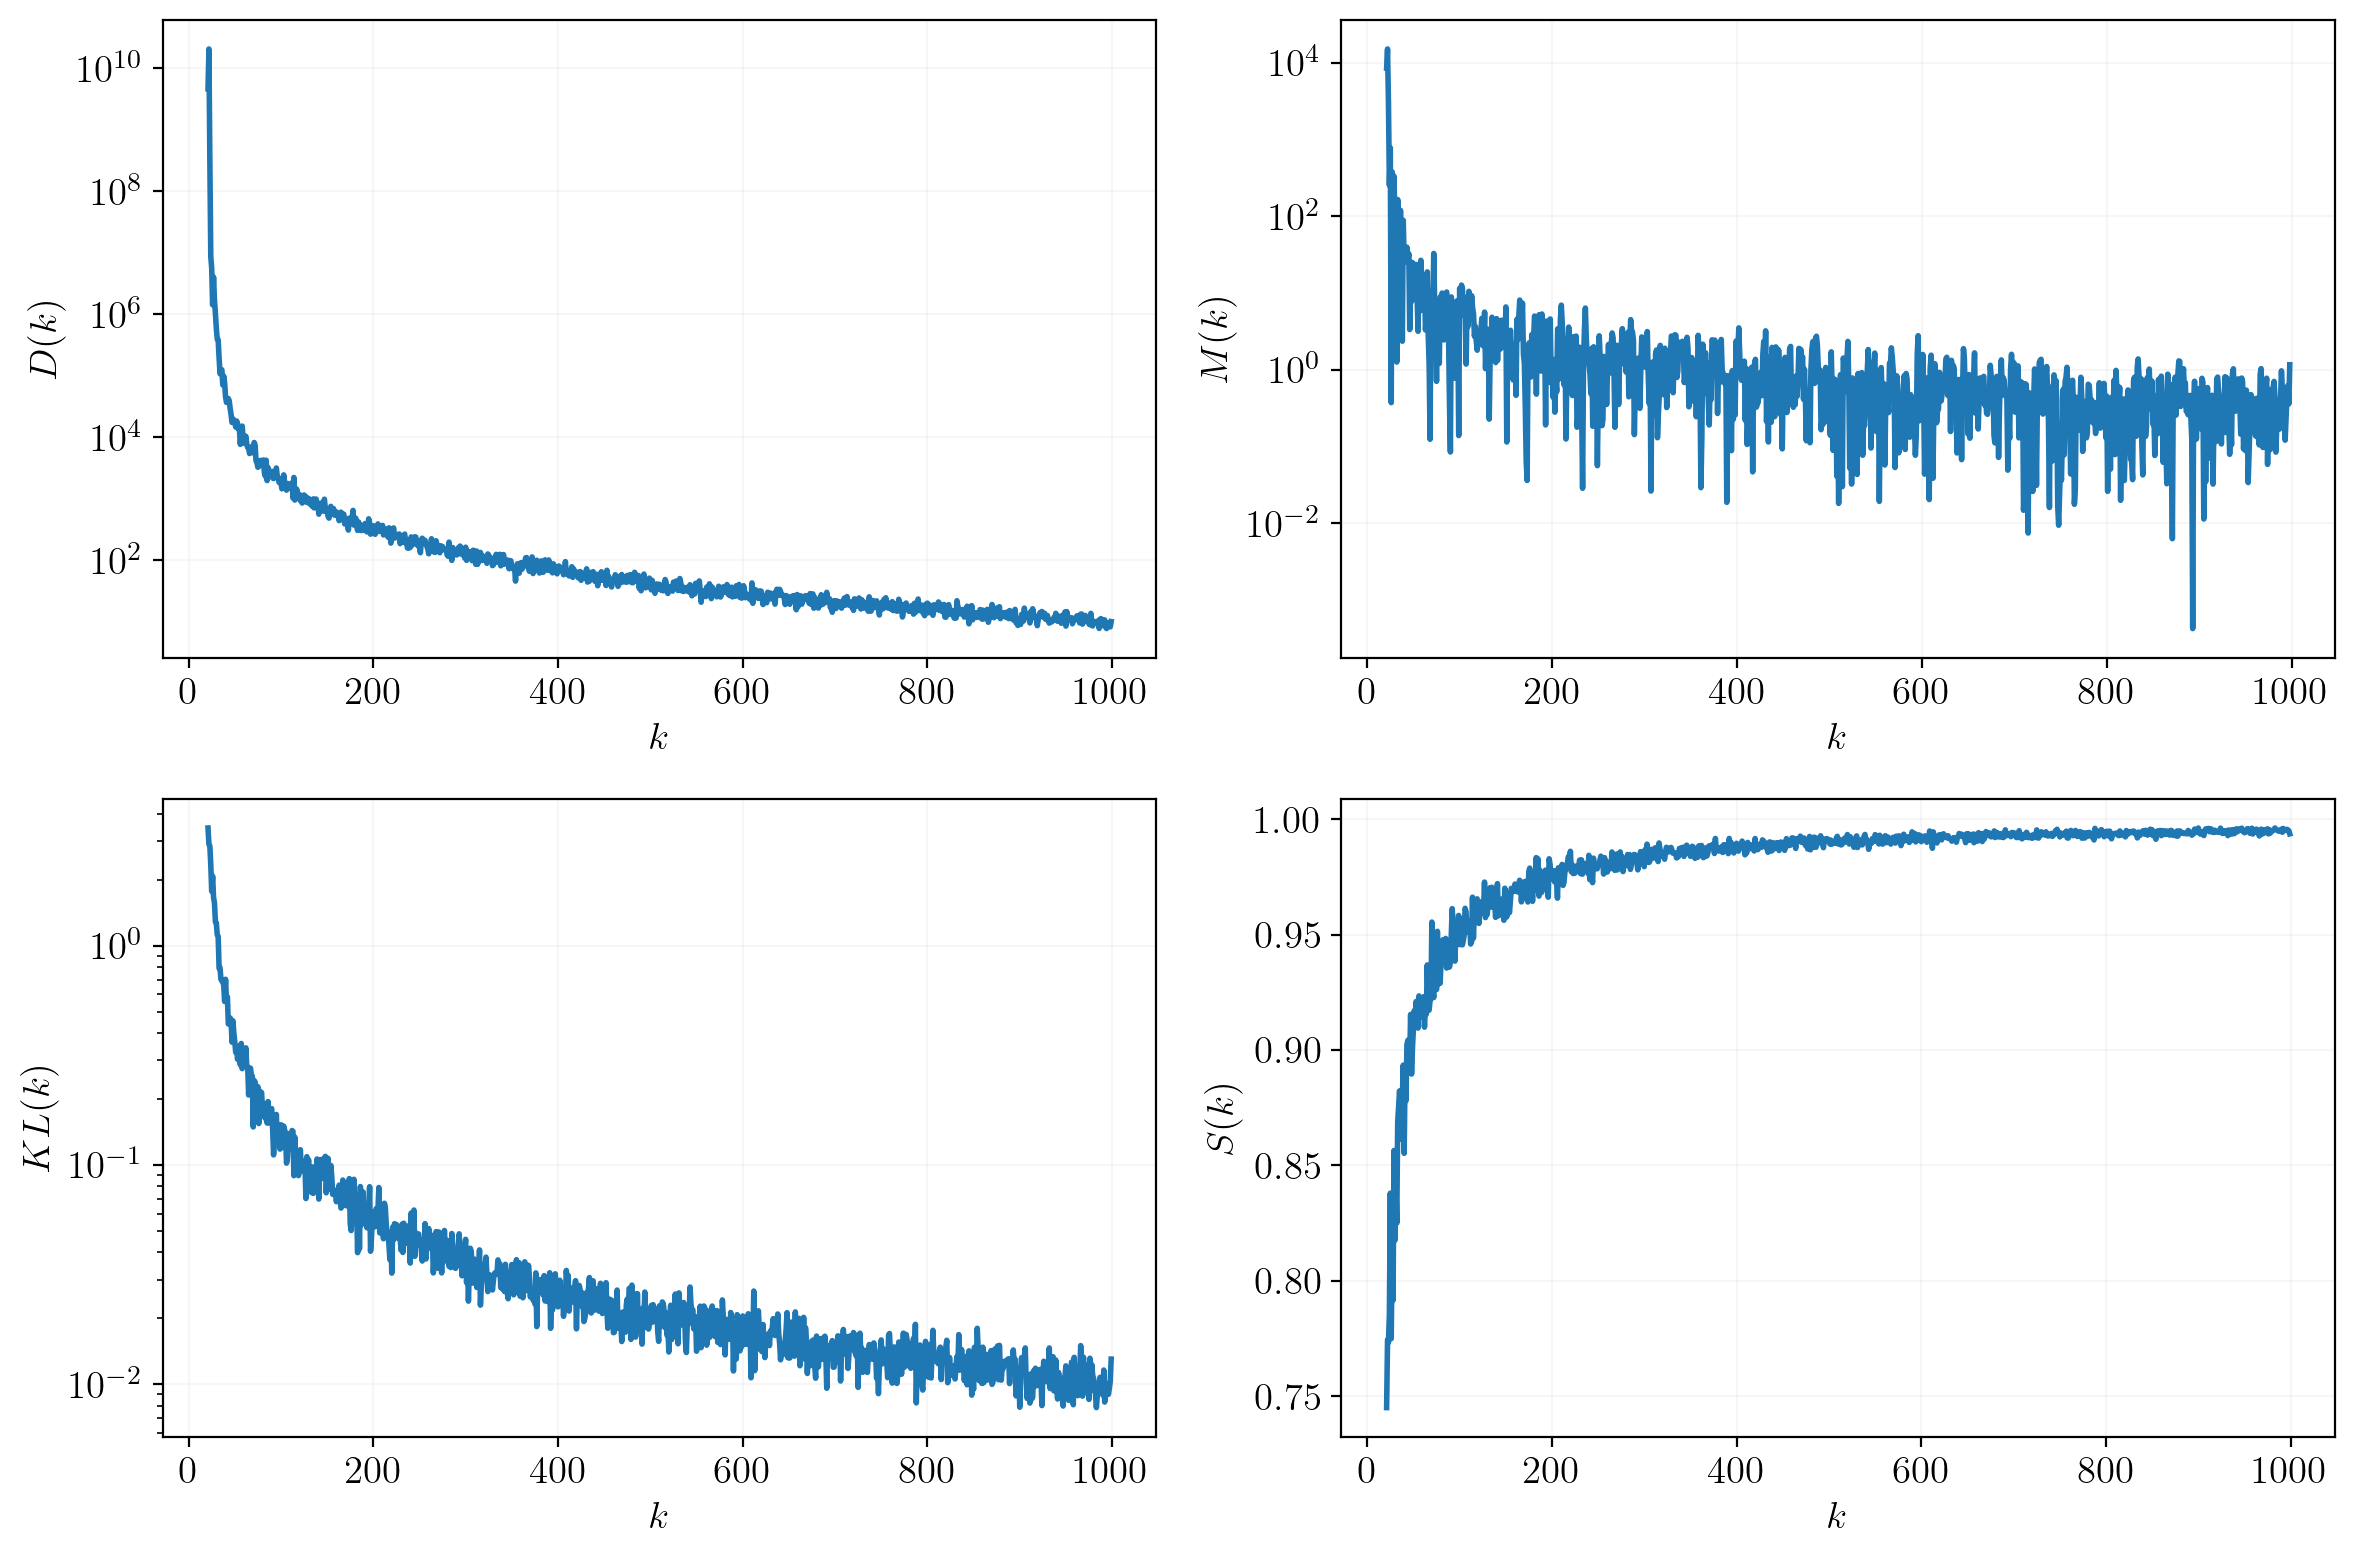

In [69]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0][0].plot(sample_sizes, D(means, variances))
ax[0][0].set_yscale("log")
ax[0][0].set_ylabel(r"$D(k)$")
ax[0][0].set_xlabel(r"$k$")

ax[0][1].plot(sample_sizes[:-1], M(means, variances))
ax[0][1].set_yscale("log")
ax[0][1].set_ylabel(r"$M(k)$")
ax[0][1].set_xlabel(r"$k$")

ax[1][0].plot(sample_sizes, divergences)
ax[1][0].set_yscale("log")
ax[1][0].set_ylabel(r"$KL(k)$")
ax[1][0].set_xlabel(r"$k$")

ax[1][1].plot(sample_sizes, scores)
#ax[1][1].set_yscale('log')
ax[1][1].set_ylabel(r"$S(k)$")
ax[1][1].set_xlabel(r"$k$")

plt.tight_layout()
plt.savefig(figures_path+"synthetic-regression-functions"+f".{format}", bbox_inches="tight")
plt.show()

#### Определение достаточного размера выборки

С помощью техники бутстрэп сделаем оценку метематического ожидания и дисперсии

In [70]:
#sample_sizes = np.linspace(2*n, X.shape[0], 100, dtype=int)
#means, variances = get_means_and_variances(X, y, sample_sizes, "regression", sigma2=1, B=1000)

In [7]:
visualizer = Visualizer(sample_sizes, means, variances, divergences, scores, loss=False, format=format)

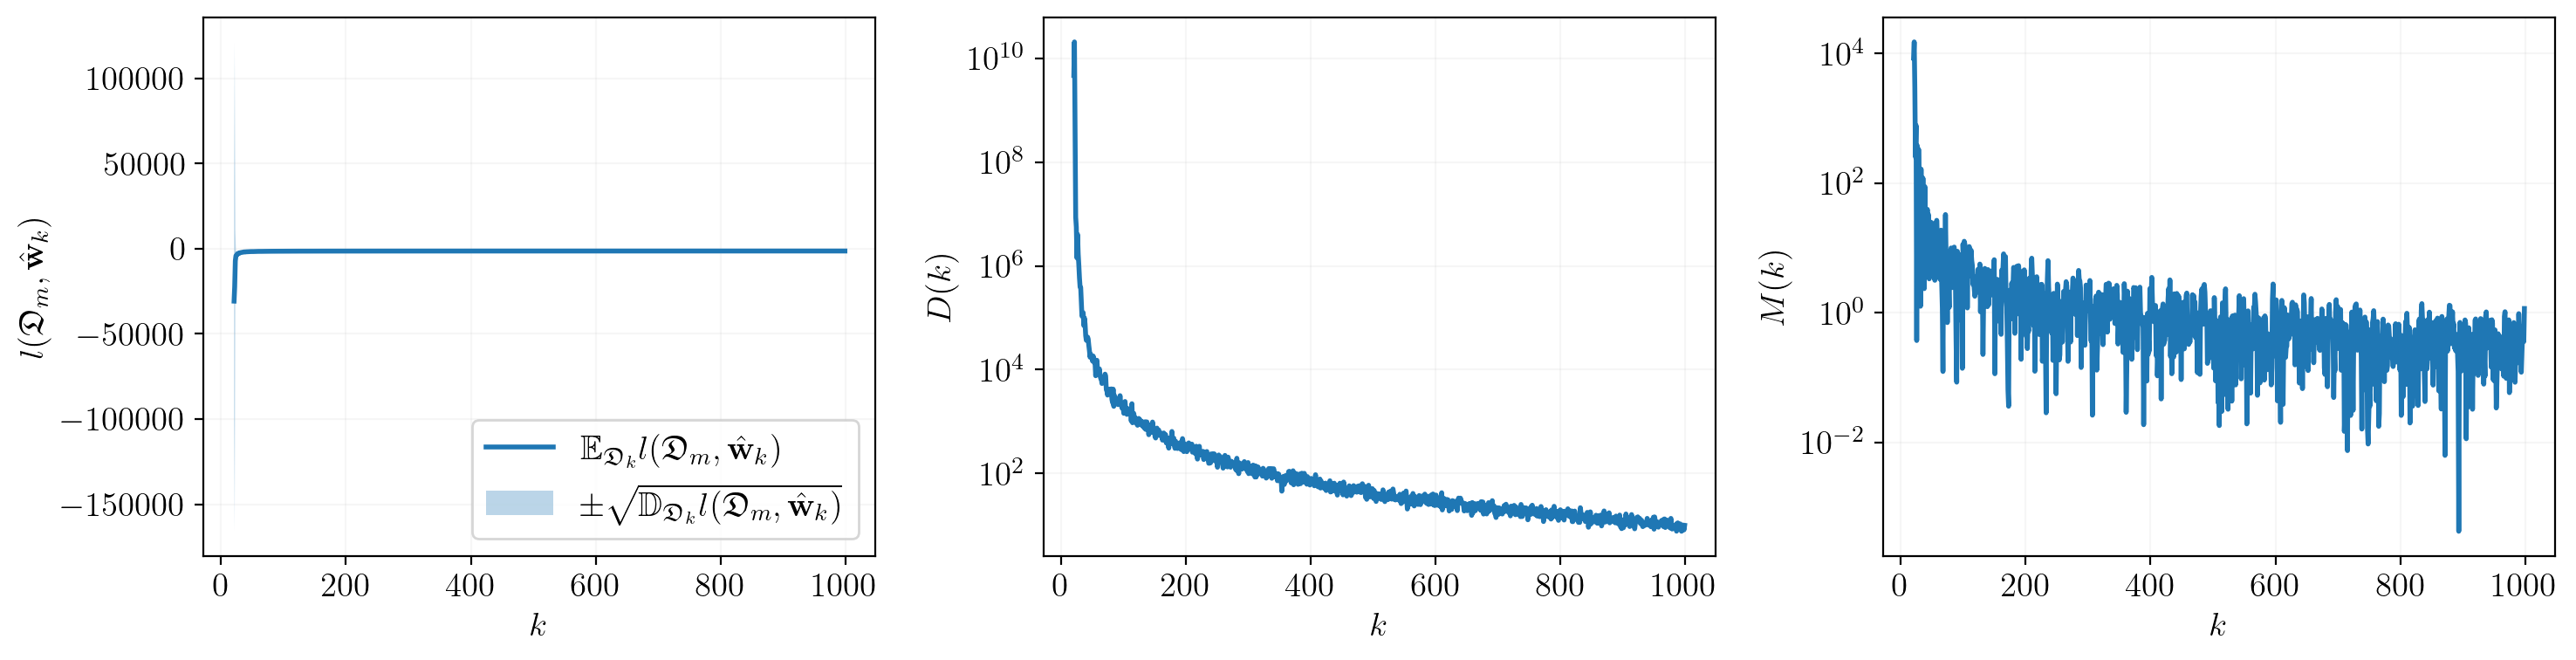

In [122]:
visualizer.plot_bootstrap()

#### Достаточный размер выборки не превосходит доступный

In [5]:
estimator = Estimator(sample_sizes, means, variances, divergences, scores)
estimator.sufficient_sample_size(eps=3e1, method="variance")
estimator.sufficient_sample_size(eps=4e-0, method="rate")

# for KL and S definitions
estimator.sufficient_sample_size(eps=5e-2, method="kl-div")
estimator.sufficient_sample_size(eps=5e-2, method="s-score")

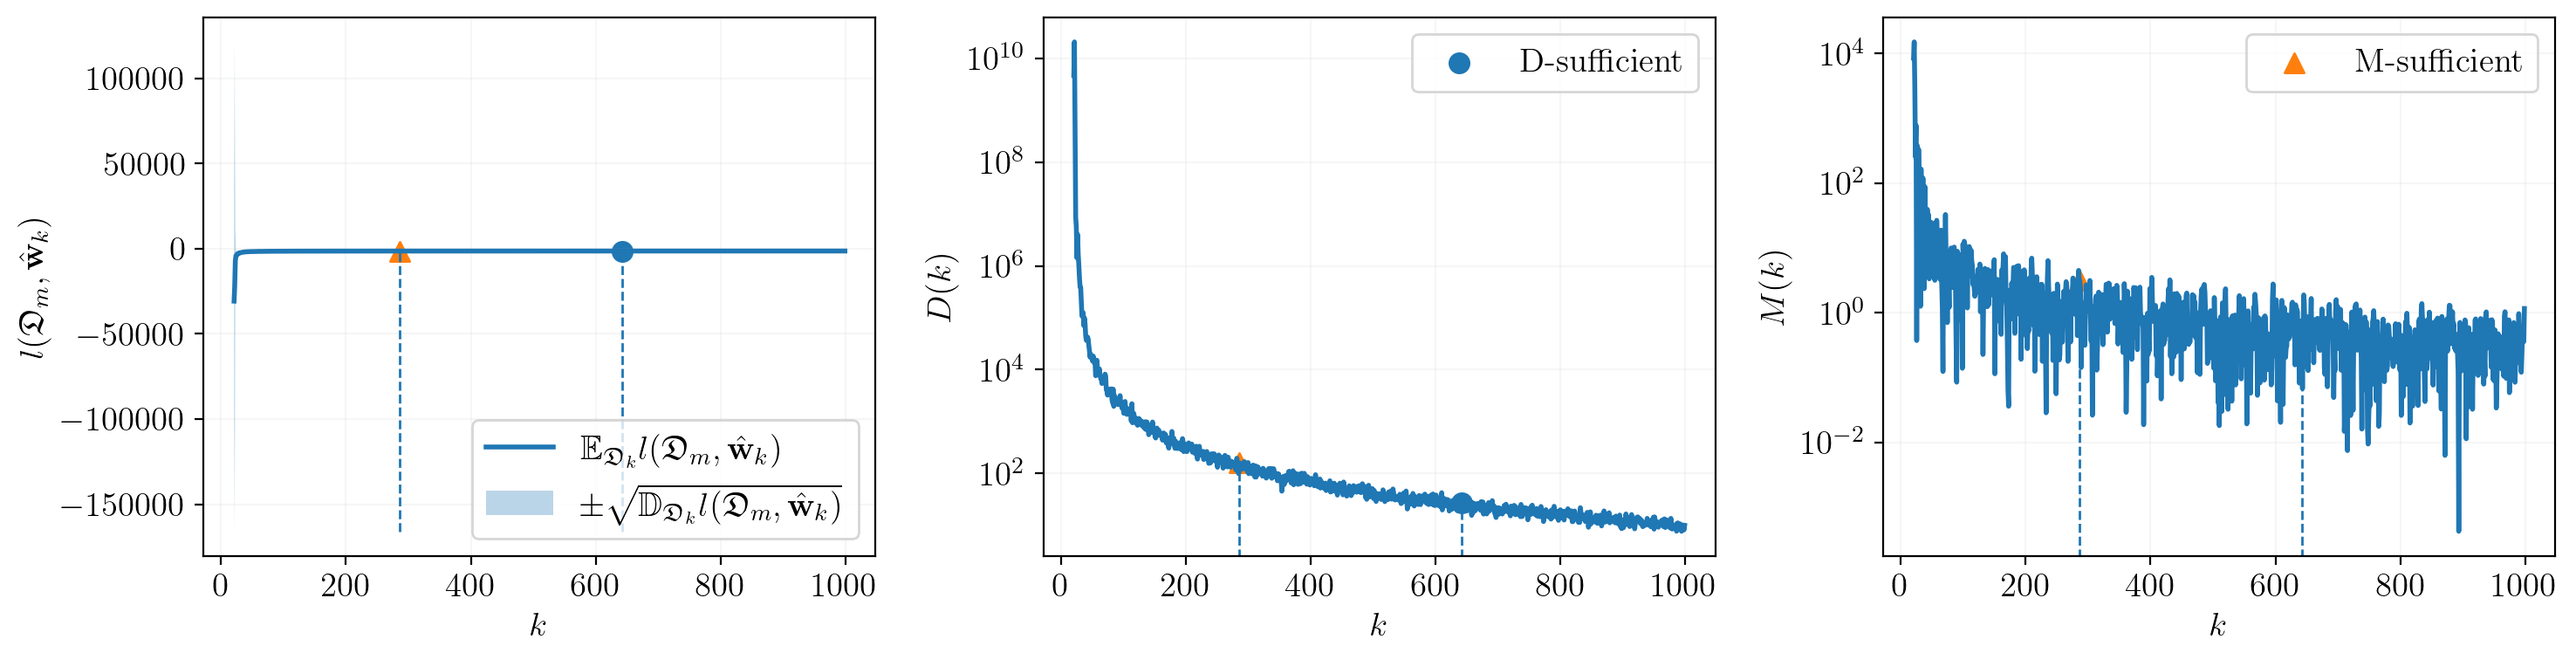

In [124]:
visualizer.plot_bootstrap_sufficient(estimator, save=True, filename=figures_path+"synthetic-regression-sufficient")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


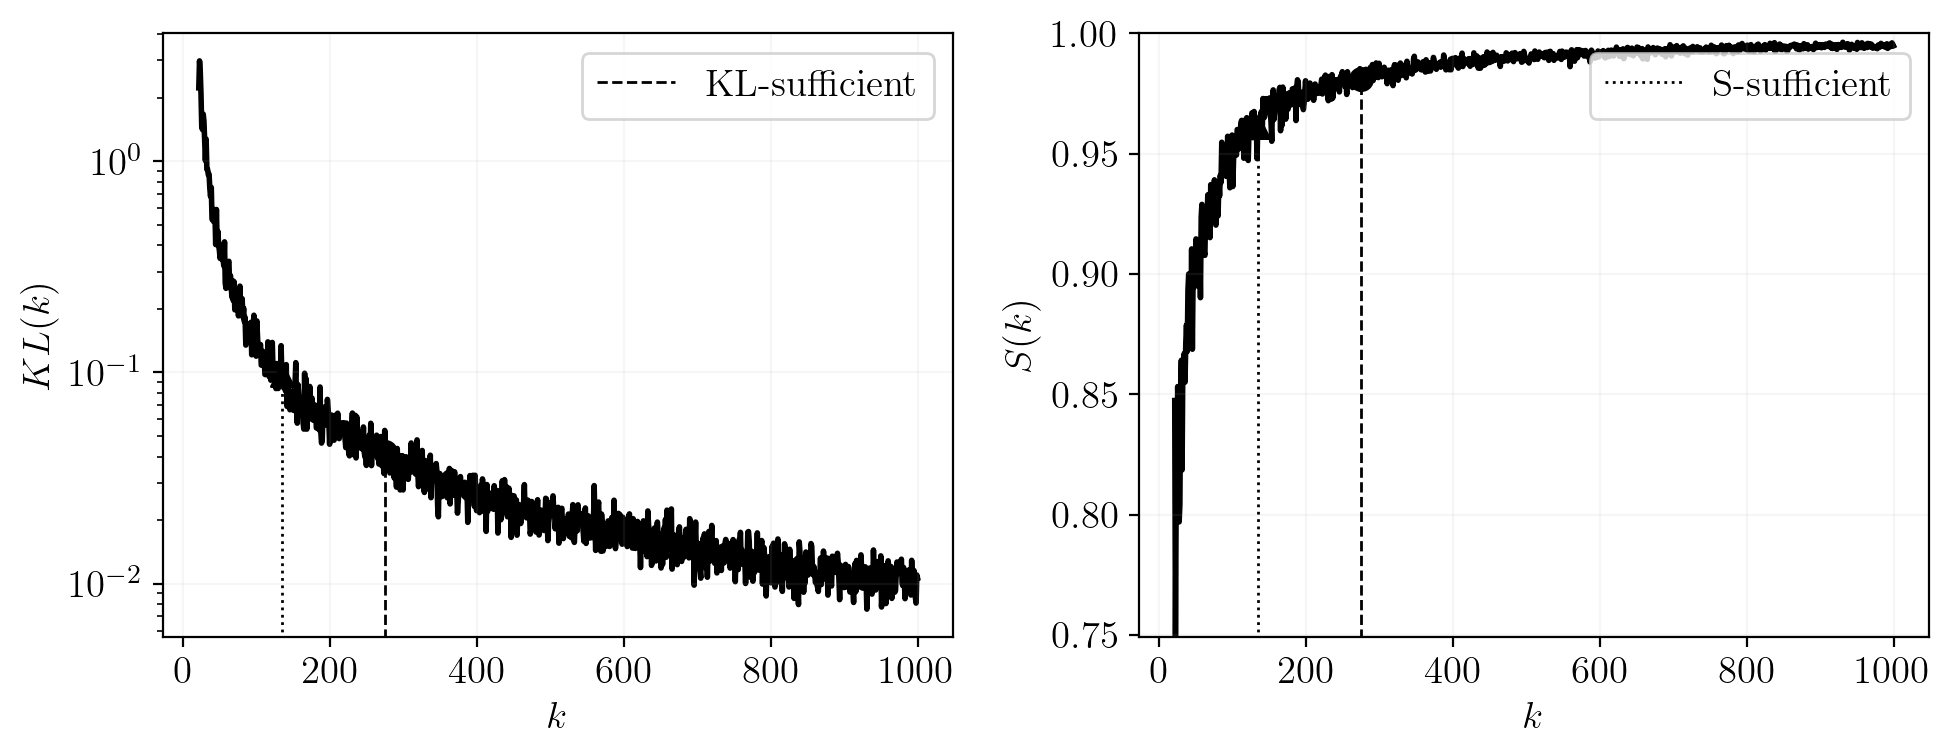

In [10]:
visualizer.plot_posterior_sufficient(estimator, save=True, 
                                     filename=figures_path+"synthetic-regression-sufficient-KL-S")

#### Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

2. Аппроксимация дисперсии

$$ \mathrm{variance}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

In [32]:
forecaster = Forecaster(sample_sizes, means, variances)
forecaster.approx(train_size=0.7)

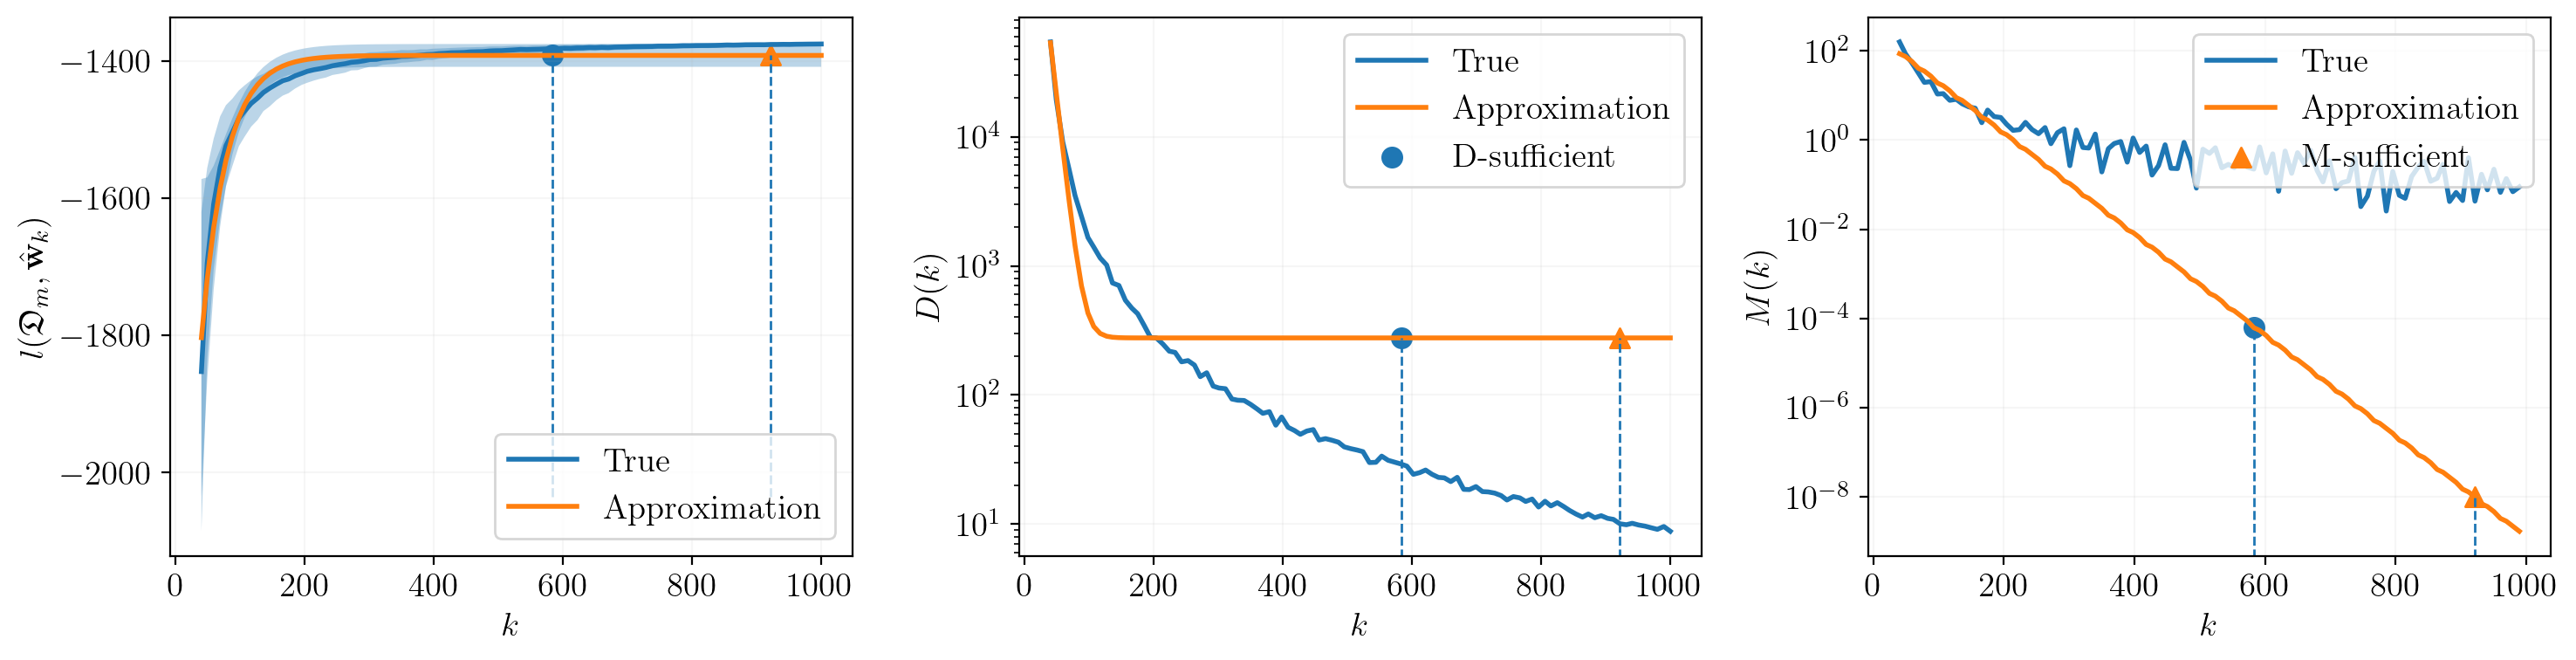

In [33]:
visualizer.plot_bootstrap_sufficient_approximation(estimator, forecaster, save=True, filename=figures_path+"synthetic-regression-approximation")

# Логистическая регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \sigma(y_i \mathbf{w}^\top \mathbf{x}_i) $$

Сгенерируем синтетическую выборку

In [38]:
def sigmoid(x):
    x = np.asarray(x)
    return 1 / (1 + np.exp(-x))

In [39]:
m = 1000 # n_samples
n = 20 # n_features

mu = np.zeros(n) # expectation of x
Sigma = np.identity(n) # covariance matrix of x

alpha = 1

X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
y = sps.bernoulli(p=sigmoid(X @ w)).rvs(size=m)
y[y == 0] = -1

С помощью техники бутстрэп сделаем оценку метематического ожидания и дисперсии

In [47]:
sample_sizes = np.linspace(2*n, X.shape[0], 50, dtype=int)
means, variances = get_means_and_variances(X, y, sample_sizes, B=1000)

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [48]:
visualizer = Visualizer(sample_sizes, means, variances, loss=False, format=format)
estimator = Estimator(sample_sizes, means, variances)

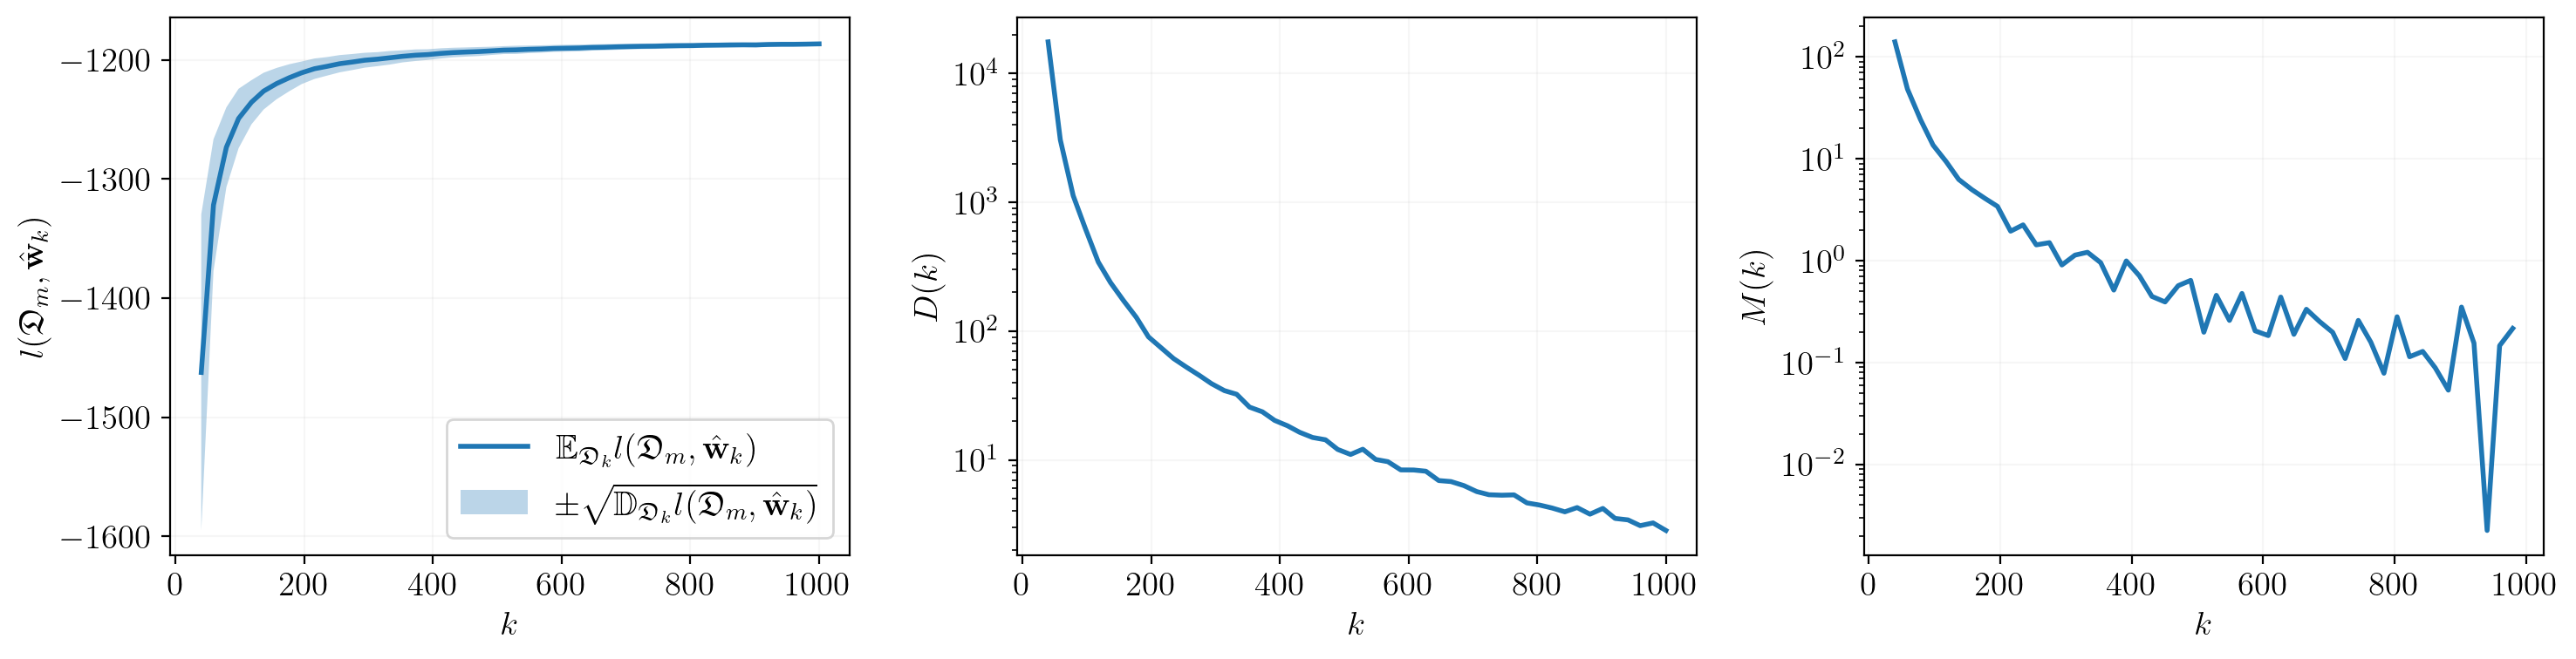

In [49]:
visualizer.plot_bootstrap()

#### Достаточный размер выборки не превосходит доступный

In [50]:
estimator = Estimator(sample_sizes, means, variances)
estimator.sufficient_sample_size(eps=3e1, method="variance")
estimator.sufficient_sample_size(eps=6e-1, method="rate")

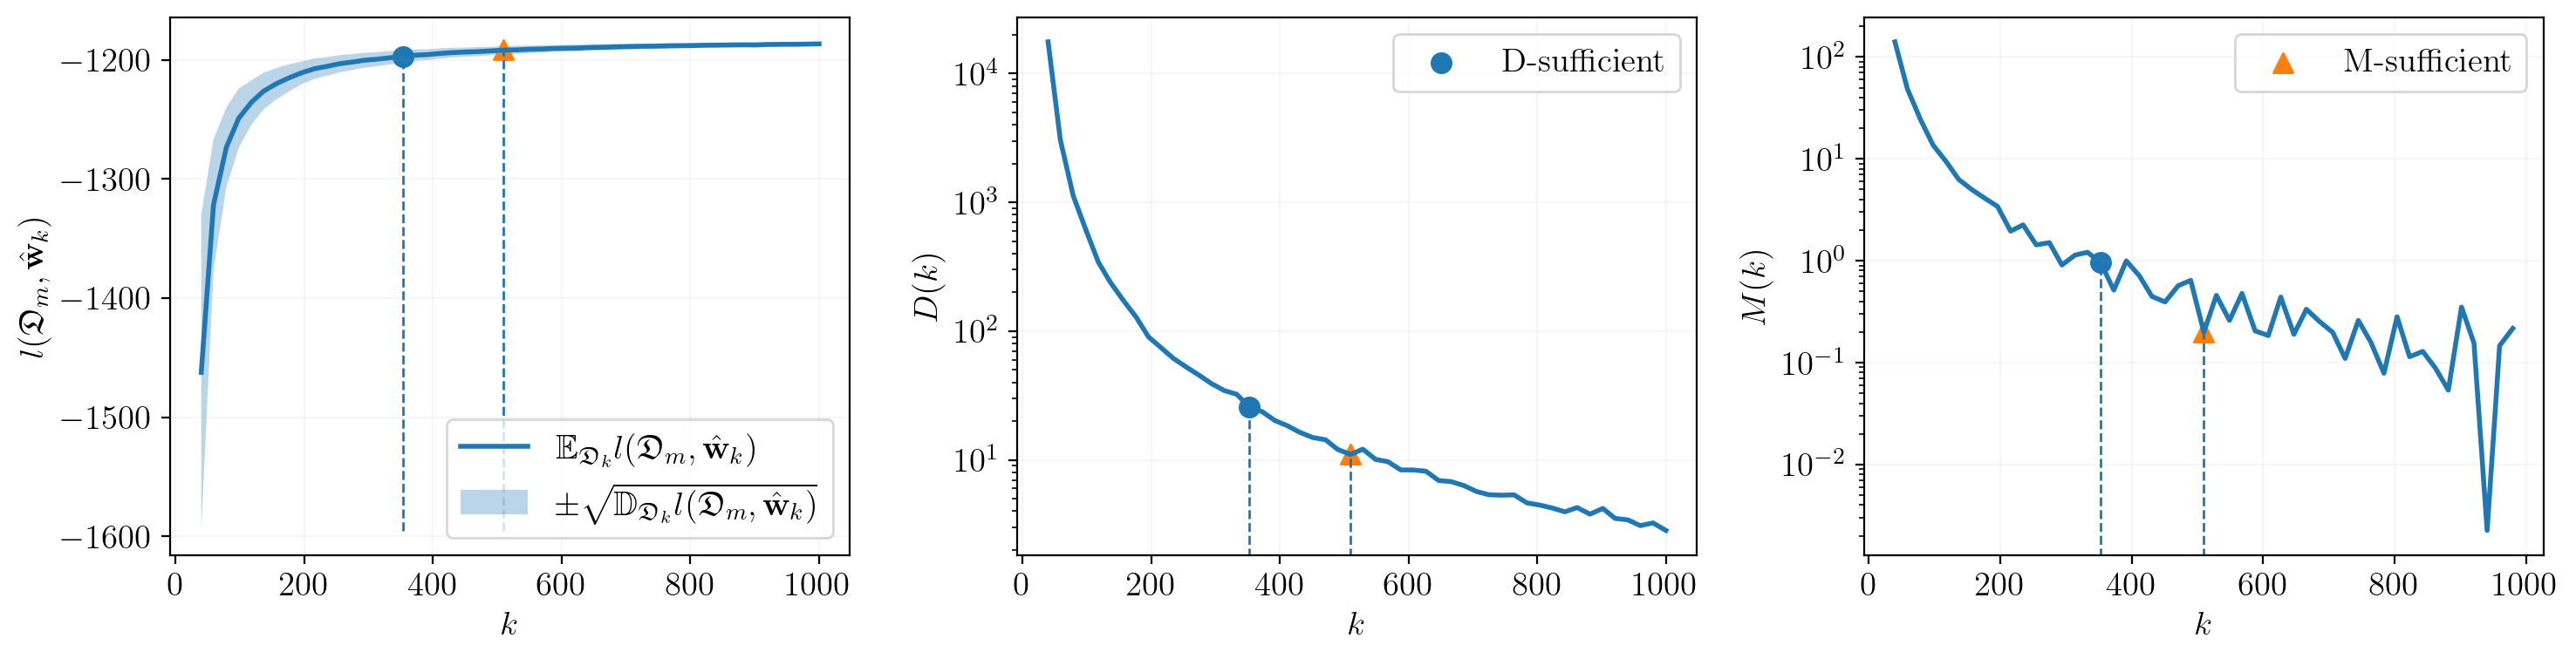

In [51]:
visualizer.plot_bootstrap_sufficient(estimator, save=True, filename=figures_path+"synthetic-classification-sufficient")

#### Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

2. Аппроксимация дисперсии

$$ \mathrm{variance}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

In [52]:
forecaster = Forecaster(sample_sizes, means, variances)
forecaster.approx(train_size=0.6)

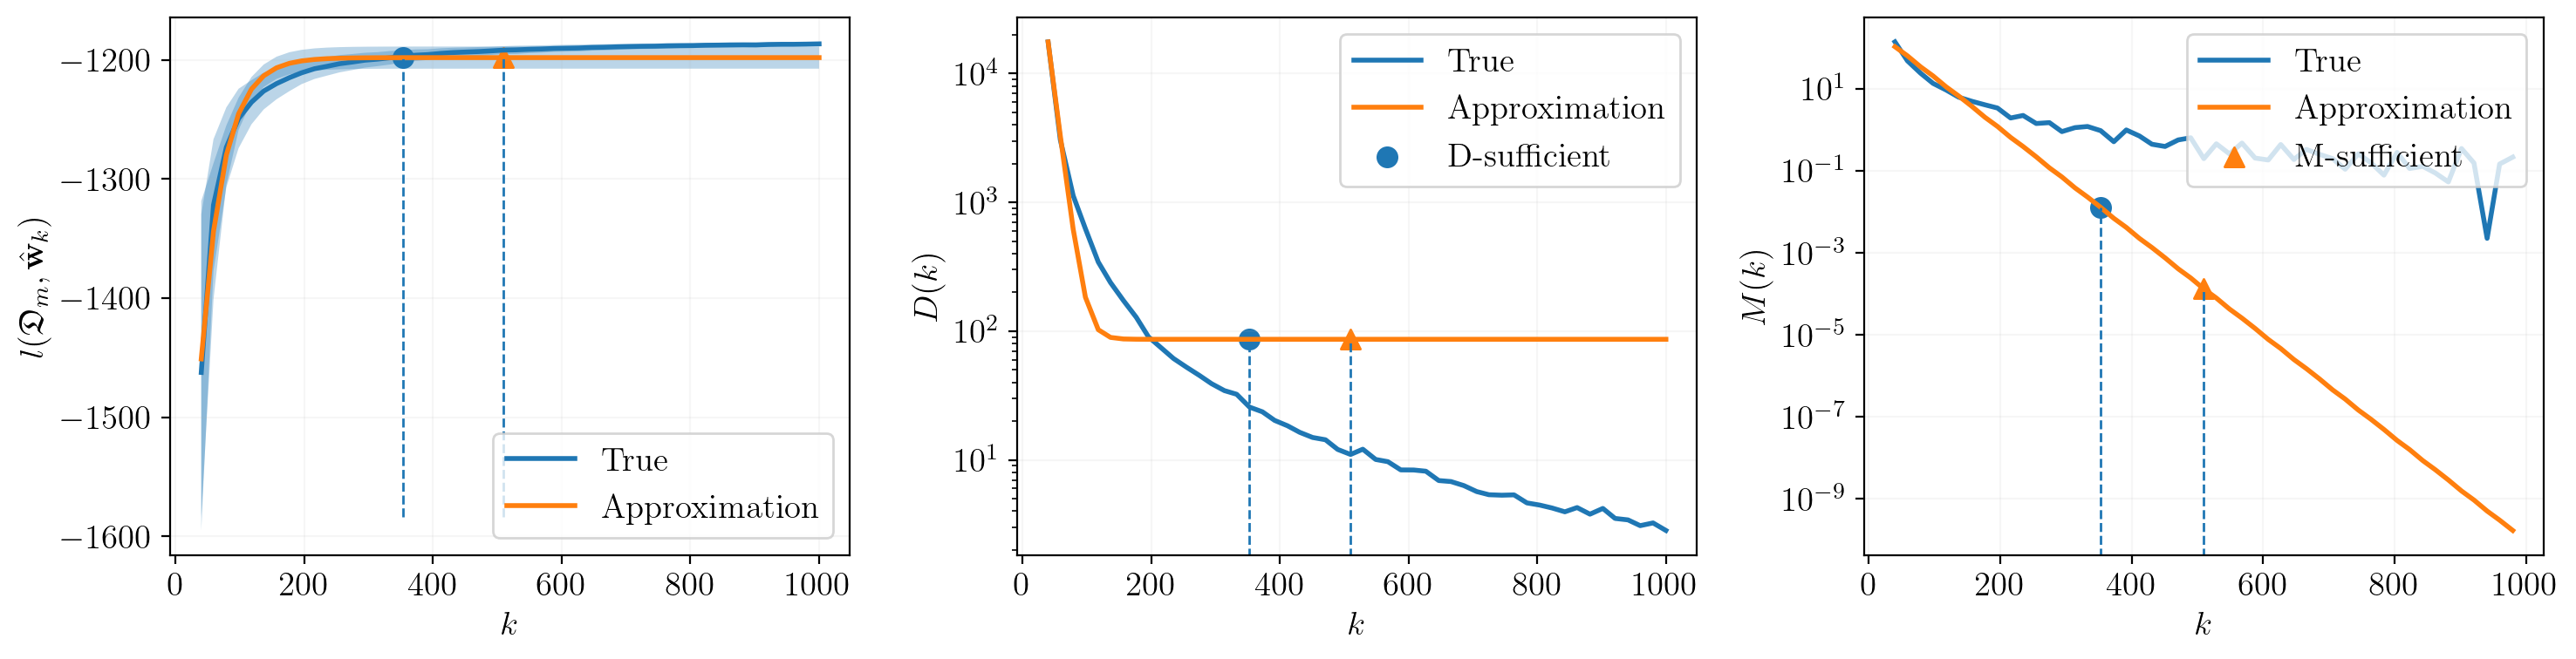

In [53]:
visualizer.plot_bootstrap_sufficient_approximation(estimator, forecaster, save=True, filename=figures_path+"synthetic-classification-approximation")

# Датасет с задачей регрессии

In [54]:
import os
import pickle

def save_object(obj, filename):
    # Overwrites any existing file.
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


def load_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
        return obj

In [55]:
results_regression = load_object("plots/datasets_regression.pkl")
results_regression.keys()

dict_keys(['Abalone', 'Auto MPG', 'Liver Disorders', 'Wine Quality', 'Parkinsons Telemonitoring', 'Bike Sharing Dataset', 'Real estate valuation', 'Heart failure clinical records'])

In [56]:
sample_sizes = results_regression['Abalone']['sample_sizes']
means = results_regression['Abalone']['mean']
stds = results_regression['Abalone']['std']

In [57]:
means *= -1
variances = stds ** 2

In [58]:
visualizer = Visualizer(sample_sizes, means, variances, loss=True, format=format)
estimator = Estimator(sample_sizes, means, variances)

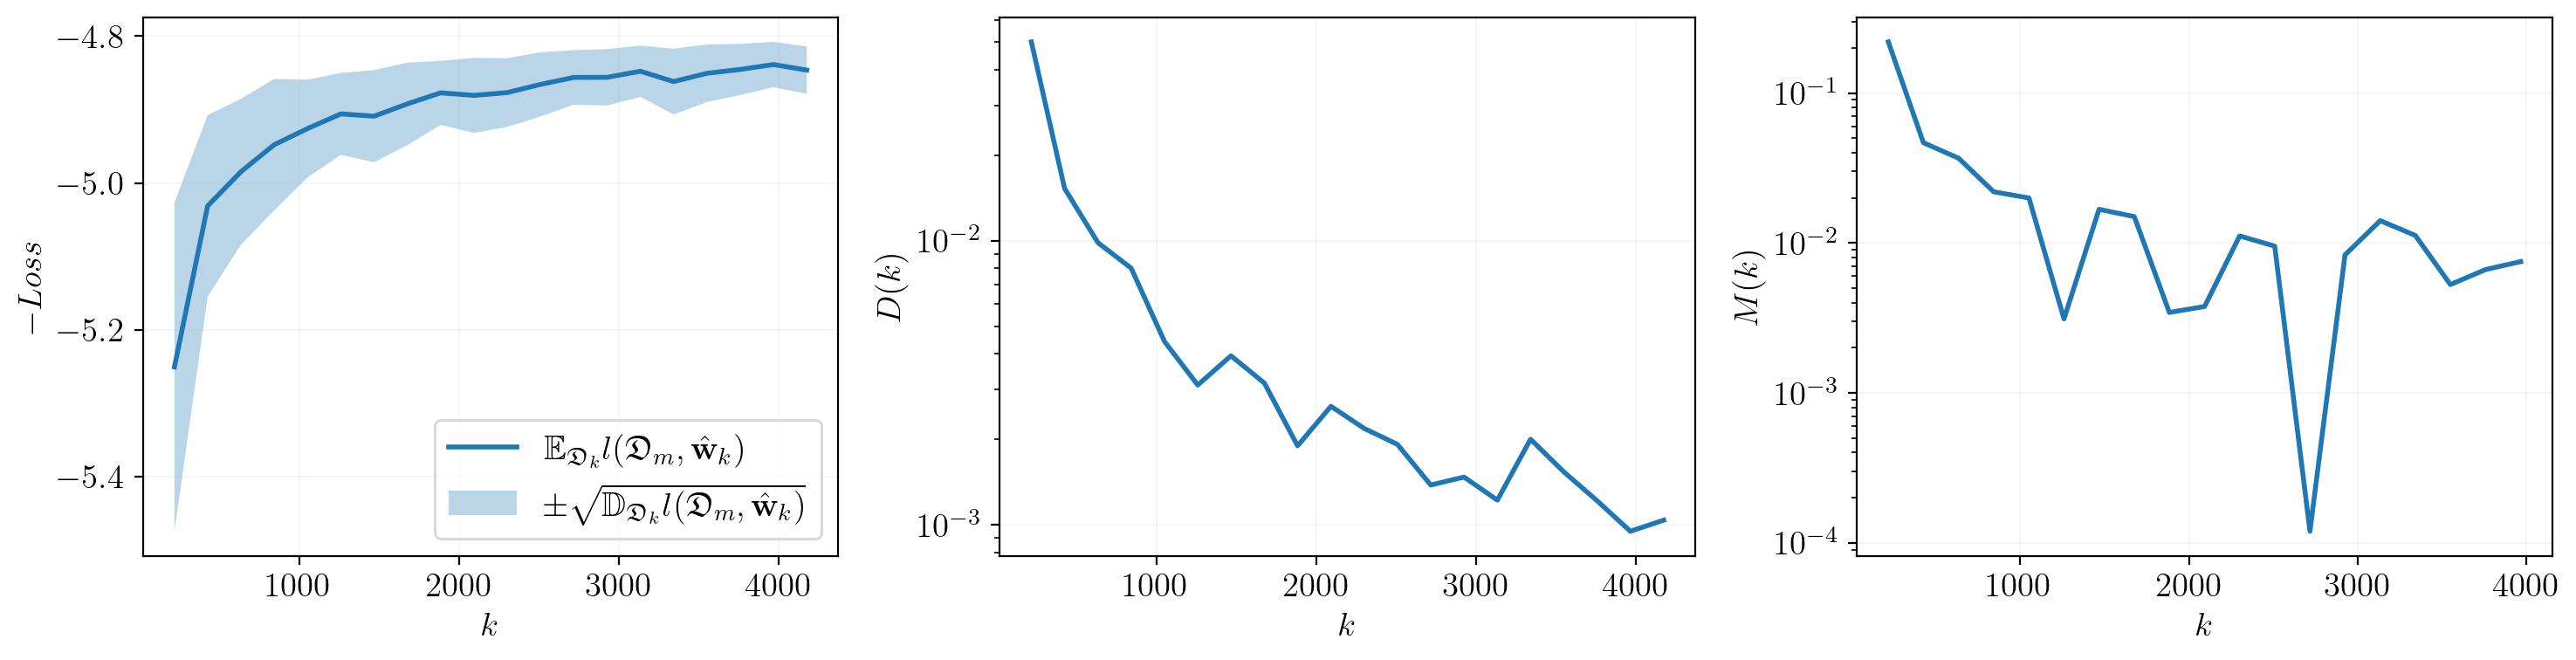

In [59]:
visualizer.plot_bootstrap()

#### Достаточный размер выборки не превосходит доступный

In [60]:
estimator = Estimator(sample_sizes, means, variances)
estimator.sufficient_sample_size(eps=2.5e-3, method="variance")
estimator.sufficient_sample_size(eps=8e-3, method="rate")

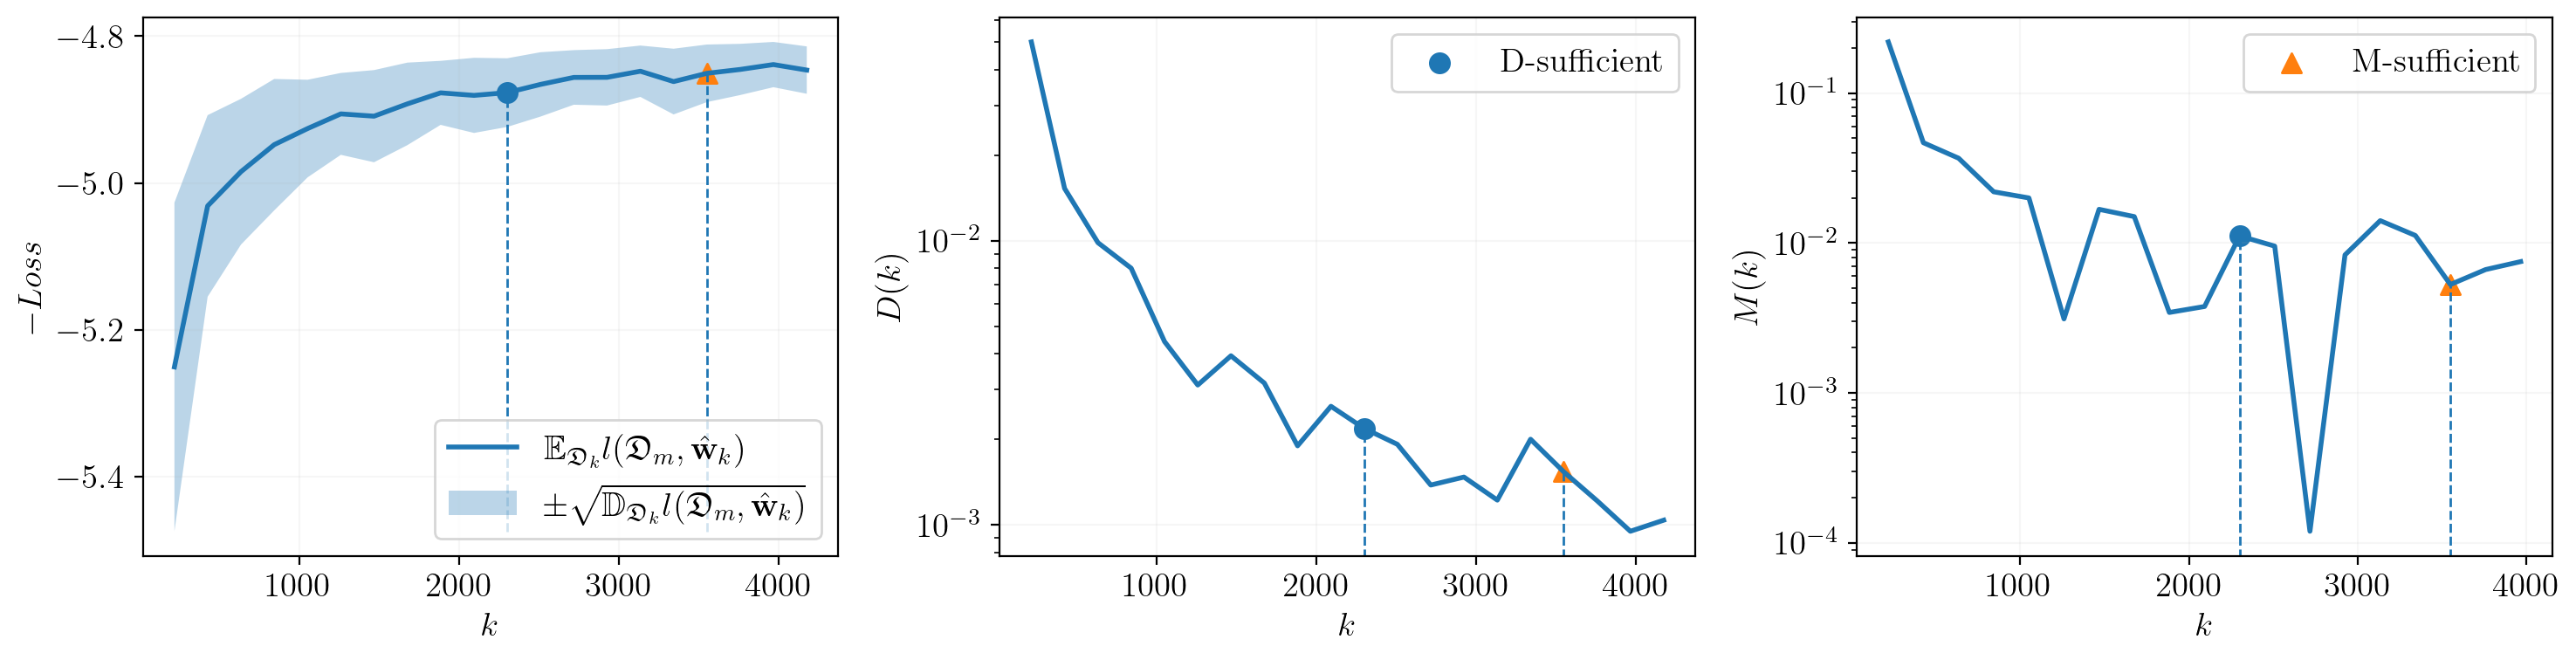

In [61]:
visualizer.plot_bootstrap_sufficient(estimator, save=True, filename=figures_path+"abalone-sufficient")

#### Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

2. Аппроксимация дисперсии

$$ \mathrm{variance}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

In [62]:
forecaster = Forecaster(sample_sizes, means, variances)
forecaster.approx()

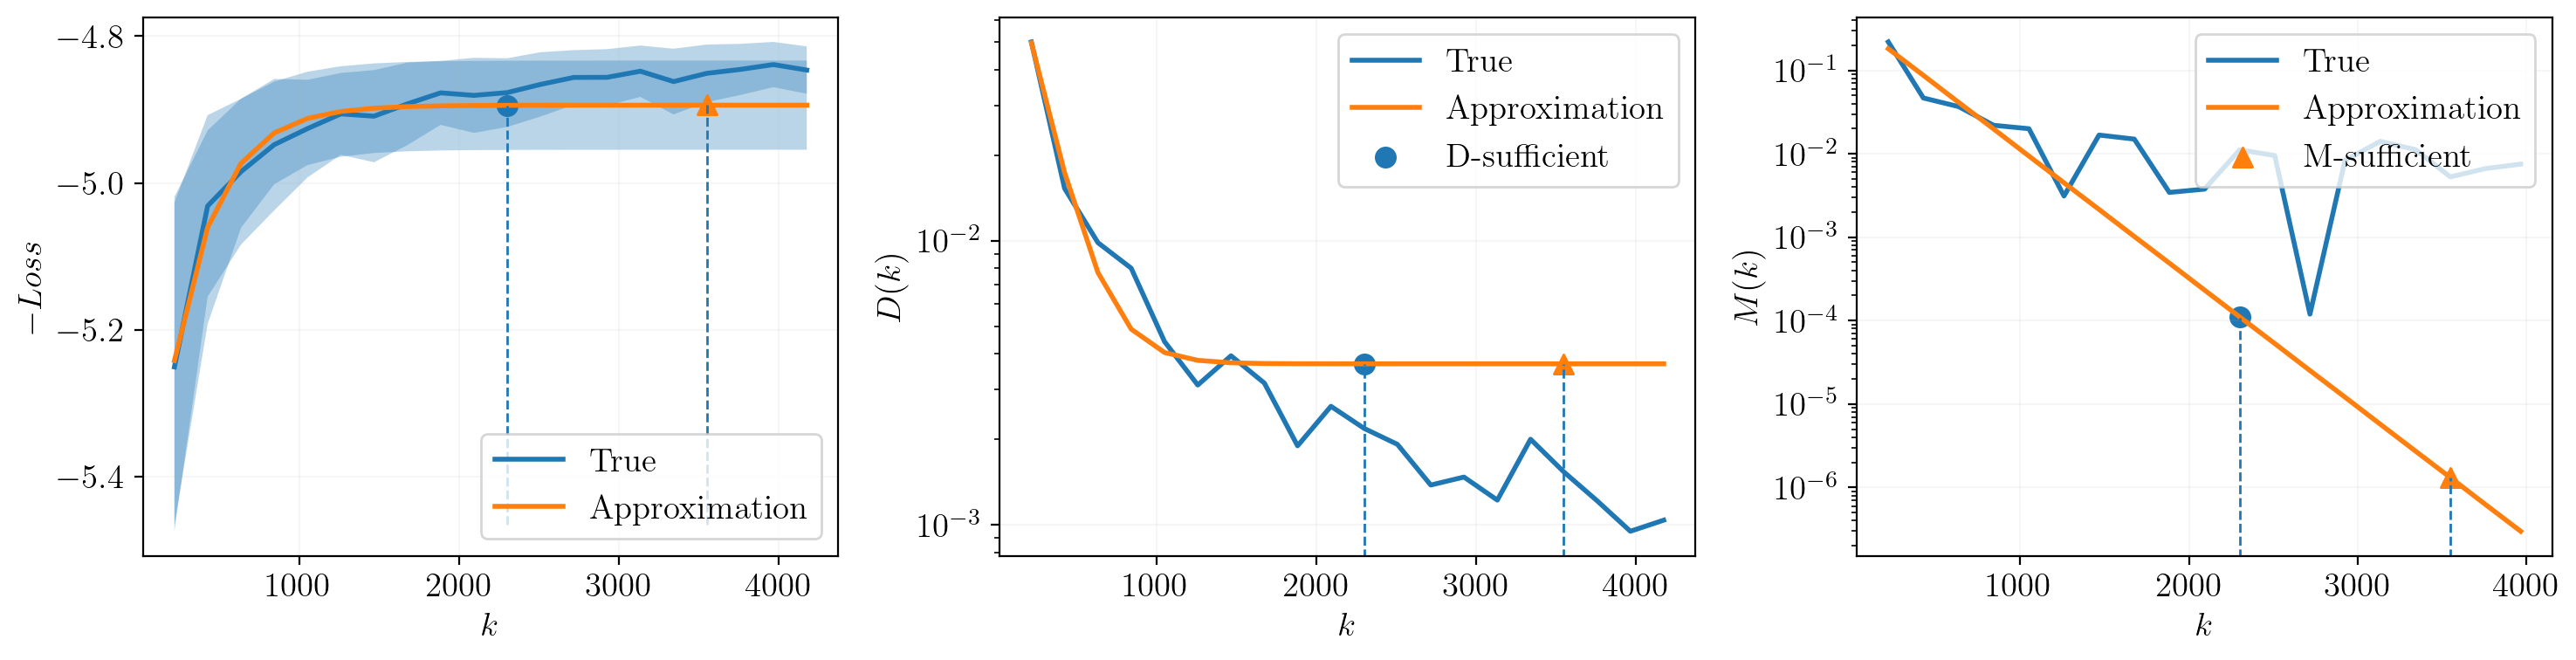

In [63]:
visualizer.plot_bootstrap_sufficient_approximation(estimator, forecaster, save=True, filename=figures_path+"abalone-approximation")